# Data Augmentation Results
This notebook will run the experiment where data augmentation is applied to the limited dataset. The model of choice is ResNet18 with the limited MNIST dataset.

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
from torch_utils import *
from augmentation_utils import mnist_dataset, create_dataloader

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

In the creation of the `data_transforms`, we have the ability to use PyTorch's built in data augmentation tools to enhance the dataset. 

In [2]:
data_transforms_orig = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [3]:
data_transforms_random_crop = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(15, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(15, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [4]:
data_transforms_hori_flip = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [5]:
data_transforms_random_rot = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [6]:
data_transforms_random_erase = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [7]:
data_transforms_all = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(10, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(10, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
}

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


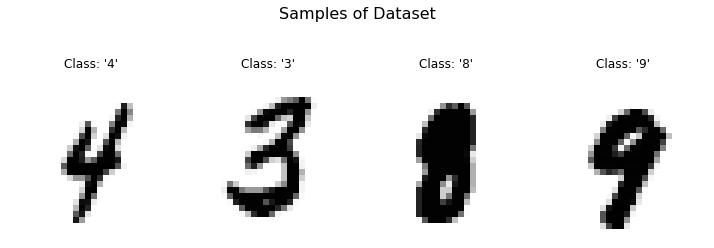

In [8]:
BATCH_SIZE = 32
limited_dataset_size = 650
pred_size=0.01

# use helper to create the dataloaders
tmp_dataset_orig = mnist_dataset(data_transforms_orig,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_orig, dataset_sizes, class_names = tmp_dataset_orig
dataloaders_orig = create_dataloader(dataset_orig, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_orig['val'])



Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


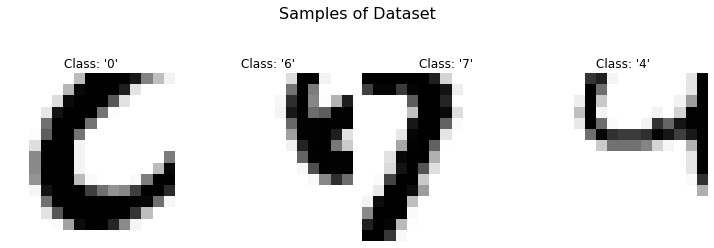

In [9]:
# use helper to create the dataloaders
tmp_dataset_random_crop = mnist_dataset(data_transforms_random_crop,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_random_crop, dataset_sizes, class_names = tmp_dataset_random_crop
dataloaders_random_crop = create_dataloader(dataset_random_crop, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_random_crop['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


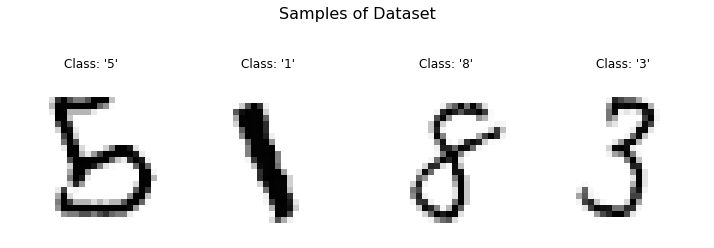

In [10]:
# use helper to create the dataloaders
tmp_dataset_hori_flip = mnist_dataset(data_transforms_hori_flip,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_hori_flip, dataset_sizes, class_names = tmp_dataset_hori_flip
dataloaders_hori_flip = create_dataloader(dataset_hori_flip, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_hori_flip['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


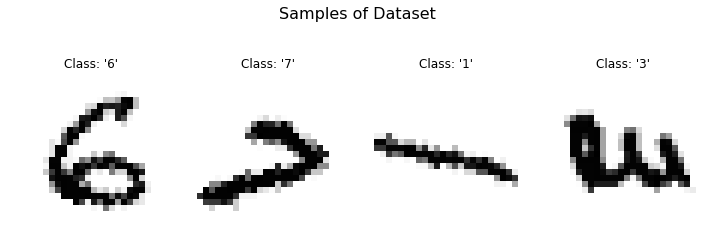

In [11]:
# use helper to create the dataloaders
tmp_dataset_random_rot = mnist_dataset(data_transforms_random_rot,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_random_rot, dataset_sizes, class_names = tmp_dataset_random_rot
dataloaders_random_rot = create_dataloader(dataset_random_rot, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_random_rot['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


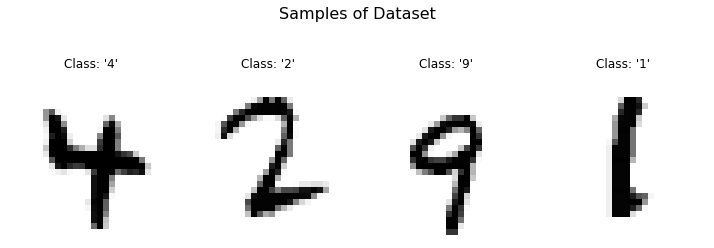

In [12]:
# use helper to create the dataloaders
tmp_dataset_random_erase = mnist_dataset(data_transforms_random_erase,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_random_erase, dataset_sizes, class_names = tmp_dataset_random_erase
dataloaders_random_erase = create_dataloader(dataset_random_erase, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_random_erase['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


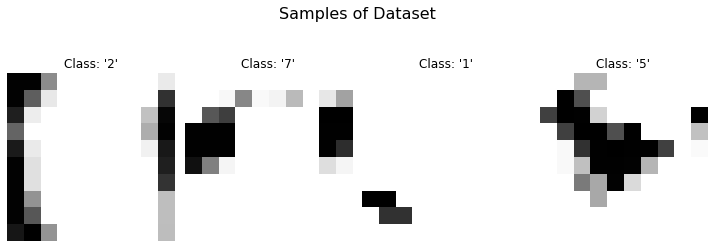

In [13]:
# use helper to create the dataloaders
tmp_dataset_all = mnist_dataset(data_transforms_all,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_all, dataset_sizes, class_names = tmp_dataset_all
dataloaders_all = create_dataloader(dataset_all, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_all['val'])

## Train the Model on the Augmented Dataset

We can then create a way to train the model and save the results.  Below is the code that was used for the training of the random crop dataset.

In [14]:
dataloaders_augmented = dataloaders_random_crop

In [16]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet18 Model
model_ResNet18Aug = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Aug.fc.in_features
model_ResNet18Aug.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Aug.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Aug)

# train ResNet18 models
model_ResNet18Aug, ResNet18Aug_df,_ = train_model(device, model_ResNet18Aug, 
                                                    dataloaders_augmented, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Augmented'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
ResNet18Aug_df.to_csv(os.path.join(output_dir,results_file),
                              columns=ResNet18Aug_df.columns)
print(f'> Saved results to \'{results_file}\'.')

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluate the Model

Now that we have trained a model, we can evalute the results using the validation datasets. Below is the code for evaluating the model. In the below example we perform the validation on the random crop transformed dataset. 

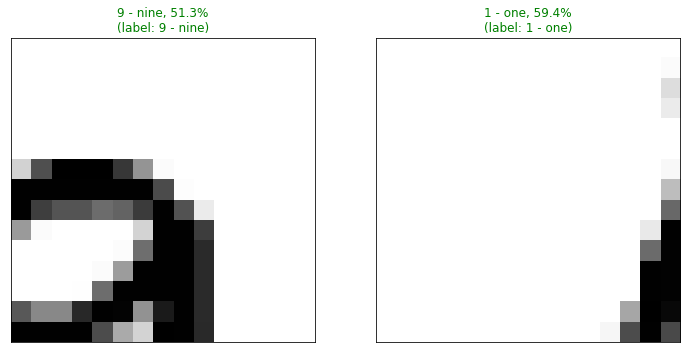

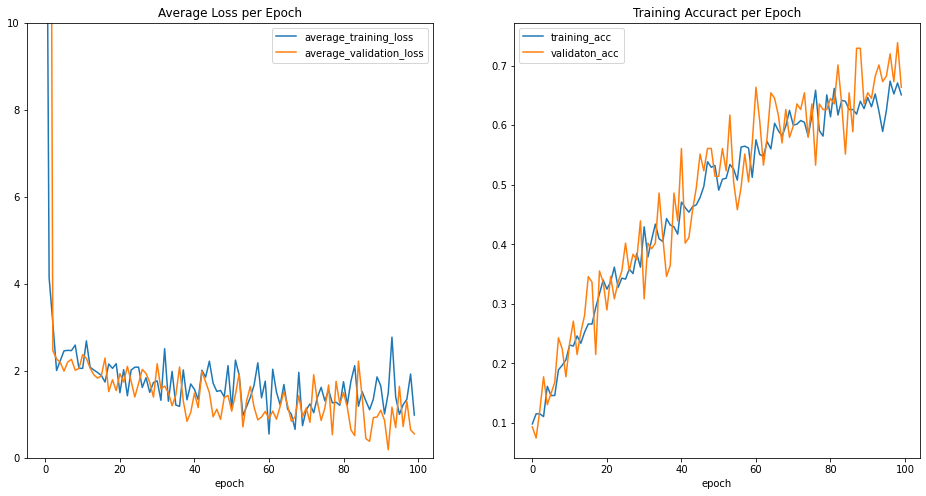

In [18]:
# Evaluate the model using the prediction set held-off
model_ResNet18Aug.eval()
dataloader_iter = iter(dataloaders_augmented['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18Aug,inputs,labels,class_names) 
plt.plot()


# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
ResNet18Aug_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,10])
ResNet18Aug_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')
model_name = 'ResNet18Augmented_RandomCrop'
img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

## Evaluate Remaining Models

After seeing the results for the random crop dataset, we can repeat the implementation for the remaining transformed datasets.

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

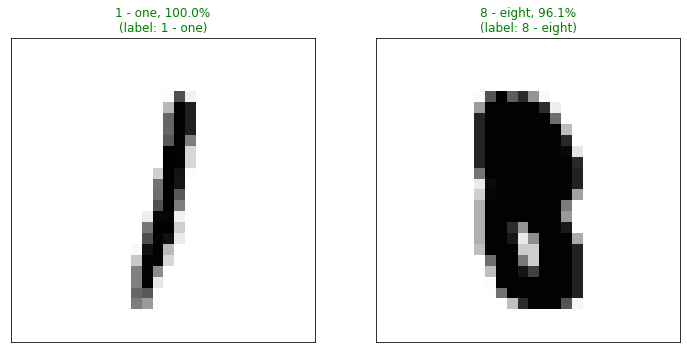

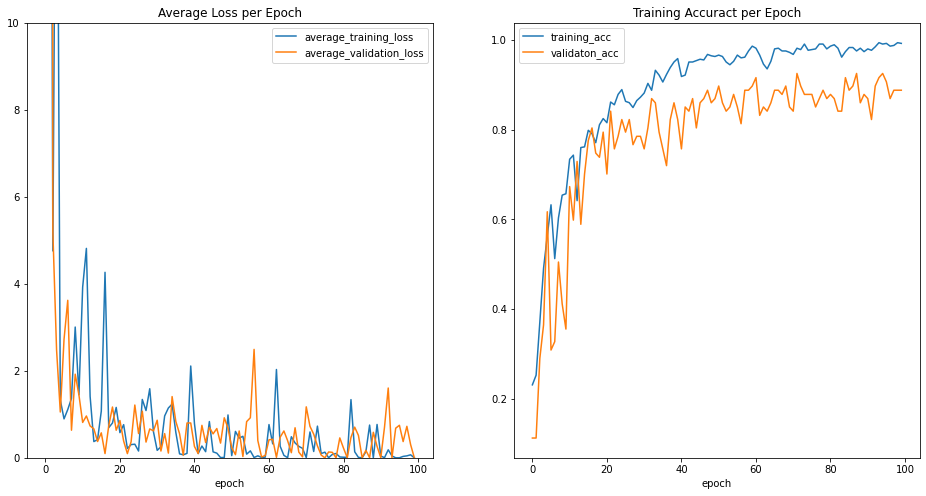

In [19]:
dataloaders_augmented = dataloaders_hori_flip

###############################################################

NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet18 Model
model_ResNet18Aug = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Aug.fc.in_features
model_ResNet18Aug.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Aug.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Aug)

# train ResNet18 models
model_ResNet18Aug, ResNet18Aug_df,_ = train_model(device, model_ResNet18Aug, 
                                                    dataloaders_augmented, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Augmented_HorizontalFlip'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
ResNet18Aug_df.to_csv(os.path.join(output_dir,results_file),
                              columns=ResNet18Aug_df.columns)
print(f'> Saved results to \'{results_file}\'.')


###############################################################

# Evaluate the model using the prediction set held-off
model_ResNet18Aug.eval()
dataloader_iter = iter(dataloaders_augmented['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18Aug,inputs,labels,class_names) 
plt.plot()


# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
ResNet18Aug_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,10])
ResNet18Aug_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

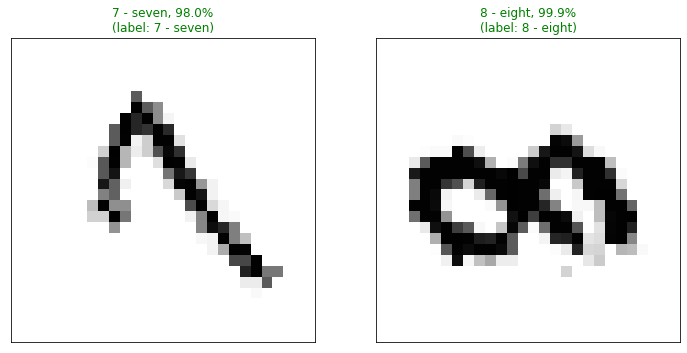

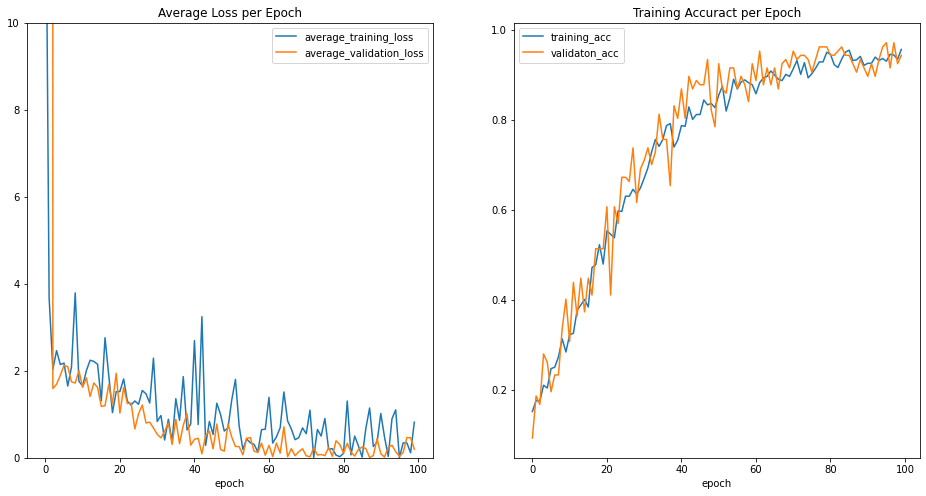

In [20]:
dataloaders_augmented = dataloaders_random_rot

###############################################################

NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet50 Model
model_ResNet18Aug = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Aug.fc.in_features
model_ResNet18Aug.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Aug.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Aug)

# train ResNet50 models
model_ResNet18Aug, ResNet18Aug_df,_ = train_model(device, model_ResNet18Aug, 
                                                    dataloaders_augmented, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Augmented_RandomRotate'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
ResNet18Aug_df.to_csv(os.path.join(output_dir,results_file),
                              columns=ResNet18Aug_df.columns)
print(f'> Saved results to \'{results_file}\'.')


###############################################################

# Evaluate the model using the prediction set held-off
model_ResNet18Aug.eval()
dataloader_iter = iter(dataloaders_augmented['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18Aug,inputs,labels,class_names) 
plt.plot()


# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
ResNet18Aug_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,10])
ResNet18Aug_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

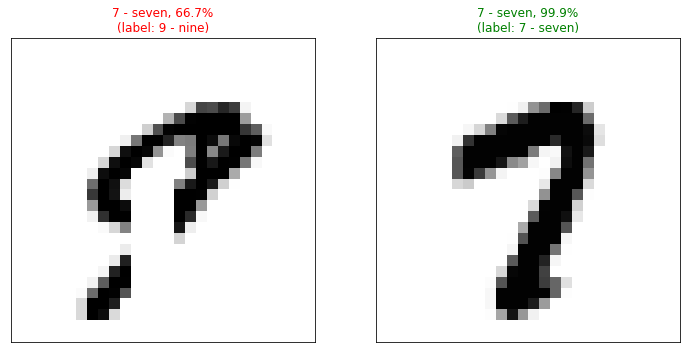

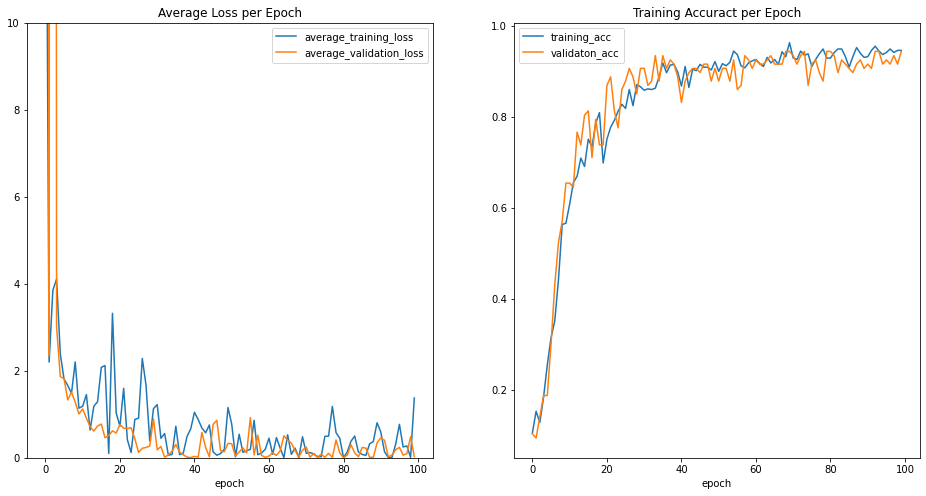

In [21]:
dataloaders_augmented = dataloaders_random_erase

###############################################################

NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet50 Model
model_ResNet18Aug = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Aug.fc.in_features
model_ResNet18Aug.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Aug.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Aug)

# train ResNet50 models
model_ResNet18Aug, ResNet18Aug_df,_ = train_model(device, model_ResNet18Aug, 
                                                    dataloaders_augmented, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Augmented_RandomErase'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
ResNet18Aug_df.to_csv(os.path.join(output_dir,results_file),
                              columns=ResNet18Aug_df.columns)
print(f'> Saved results to \'{results_file}\'.')


###############################################################

# Evaluate the model using the prediction set held-off
model_ResNet18Aug.eval()
dataloader_iter = iter(dataloaders_augmented['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18Aug,inputs,labels,class_names) 
plt.plot()


# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
ResNet18Aug_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,10])
ResNet18Aug_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

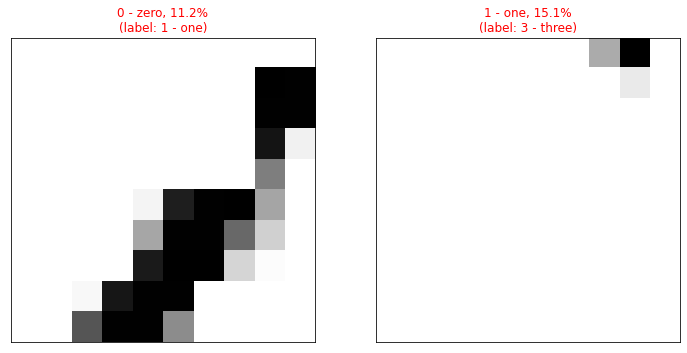

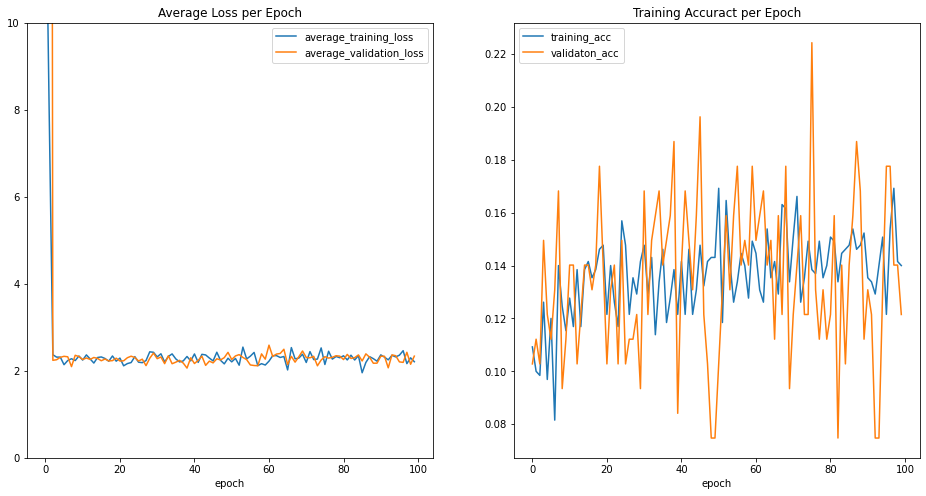

In [22]:
dataloaders_augmented = dataloaders_all

###############################################################

NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet50 Model
model_ResNet18Aug = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Aug.fc.in_features
model_ResNet18Aug.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Aug.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Aug)

# train ResNet50 models
model_ResNet18Aug, ResNet18Aug_df,_ = train_model(device, model_ResNet18Aug, 
                                                    dataloaders_augmented, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Augmented_All'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
ResNet18Aug_df.to_csv(os.path.join(output_dir,results_file),
                              columns=ResNet18Aug_df.columns)
print(f'> Saved results to \'{results_file}\'.')


###############################################################

# Evaluate the model using the prediction set held-off
model_ResNet18Aug.eval()
dataloader_iter = iter(dataloaders_augmented['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18Aug,inputs,labels,class_names) 
plt.plot()


# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
ResNet18Aug_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,10])
ResNet18Aug_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

## Conclusion
In closing, this notebook was intended to provide the implementation results of a set of data augmentation experiments. We see that randome erase and random rotate performed the best. Random crop performed the worst. One hypothesis for this would be that because portions of the image were gone, the model was confused between a few classes. For example removing a portion of the number six could result in classification as a 0. One way to fix this would be to fine tune the crop such that it is small enough to not remove those areas. An additional experiment was run just to see what happens if a dataset with all four transforms was created and trained with. This yielded the worst accuracy most likely due to the fact that there were so many transforms applied that the resulting image did not even look like a number. 

## References:
[1] https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
[2] Y. Oh, S. Park and J. C. Ye, "Deep Learning COVID-19 Features on CXR Using Limited Training Data Sets," in IEEE Transactions on Medical Imaging, vol. 39, no. 8, pp. 2688-2700, Aug. 2020, doi: 10.1109/TMI.2020.2993291.
[3] X. Peng, N. Ratha and S. Pankanti, “Learning face recognition from limited training data using deep neural networks,” 2016 23rd International Conference on Pattern Recognition (ICPR), Cancun, 2016, pp. 1442–1447, doi: 10.1109/ICPR.2016.7899840.